#### **1. Importing Required Package and Modules**

Installation of the necessary modules.

In [ ]:
%pip install seaborn
%pip install scikit-learn
%pip install matplotlib
%pip install aisp

In [ ]:
# Importing the negative selection.
from aisp.nsa import BNSA

# Importing other packages. 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Function to generate binary samples
In this function, samples of binary data with a degree of similarity above a defined threshold s are generated. However, the first 10% of the data is generated randomly, without taking into account the value of s. Furthermore, when there are already samples, unique samples are generated for the new class, ensuring that the random samples generated are not duplicated in different classes.

In [2]:
def generate_samples(n_samples: int, n_features: int, s: float, x: None):
   class_samples = []
   while len(class_samples) < n_samples:
     similarity = 0
     sample_rand = np.random.randint(0, 2, size=(n_features))
     if(len(class_samples) > max(int(n_samples * 0.1), 1)):
       similarity = cdist(class_samples, np.expand_dims(sample_rand, axis=0), metric='hamming')[0, :]
       if x is not None:
         if similarity[0] <= s and not np.any(np.all(sample_rand == x, axis=1)):
           class_samples.append(sample_rand)
       elif similarity[0] <= s:
         class_samples.append(sample_rand)
     else:
       class_samples.append(sample_rand)
   return np.array(class_samples)

# Data generation and separation

In this step, 1000 pieces of data are generated, 500 representing class 'x' and 500 representing class 'y'. Each die is made up of 20 dimensions. It is important to highlight that these data are created in such a way that they present a degree of similarity of 70%, that is, they share common characteristics. After generation, the data is separated into training and test sets.

In [3]:
# Setting the seed to 121 to ensure the reproducibility of the generated data.
np.random.seed(121)
# Generating samples for class "A".
x = generate_samples(500, 20, 0.2, None)
# Generating unique samples for class "B", different from samples present in class "A".
y = generate_samples(500, 20, 0.2, x)
# Adding columns containing the outputs (labels) of classes "A" and "B".
x = np.hstack((x, np.full((x.shape[0], 1), 'A')))
y = np.hstack((y, np.full((y.shape[0], 1), 'B')))
# Merging the two vectors (classes "A" and "B") and randomizing the order of the samples.
index = np.random.permutation(x.shape[0]*2)
dataset = np.vstack((x, y))[index]
# Separating the characteristics (inputs) and the output classes (labels).
samples = dataset[:, :-1].astype(int)
output = dataset[:, -1]
# Data separation for training and testing.
train_x, test_x, train_y, test_y = train_test_split(samples, output, test_size=0.2, random_state=1234321)

# Testing the model
Starting the model and applying it to randomly generated samples, the current configuration consists of 250 detectors with a differentiation rate of 30%.

In [4]:
# Starting the model.
nsa = BNSA(N=250, aff_thresh=0.3, seed=1234321, max_discards=100000)
# Conducting the training:
nsa.fit(X=train_x, y=train_y)
# Visualization of classes with test samples.
prev_y = nsa.predict(test_x)
# Showing the accuracy of predictions for real data.
print(f"The accuracy is {accuracy_score(prev_y, test_y)}")
print(classification_report(test_y, prev_y))

✔ Non-self detectors for classes (A, B) successfully generated:  ┇██████████┇ 500/500 detectors


The accuracy is 0.93
              precision    recall  f1-score   support

           A       0.93      0.91      0.92        90
           B       0.93      0.95      0.94       110

    accuracy                           0.93       200
   macro avg       0.93      0.93      0.93       200
weighted avg       0.93      0.93      0.93       200



# Confusion matrix
Here is the confusion matrix, where the main diagonal represents correctly predicted samples and the secondary diagonal shows the false positives. Out of 200 test data points, there were 5 false positives for class x and 3 false positives for class y.

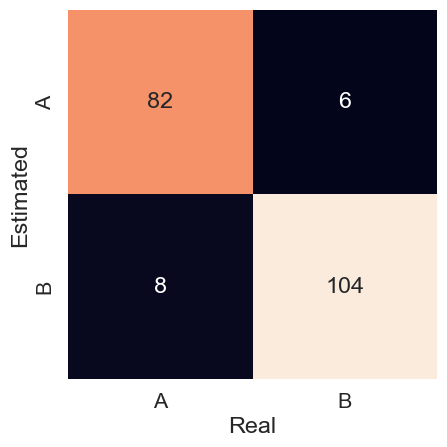

In [5]:
# Generating the confusion matrix and plotting it graphically.
mat = confusion_matrix(y_true=test_y, y_pred=prev_y)
sns.set(font_scale=1.4) 
sns.heatmap(
    mat.T, 
    square=True, 
    annot=True, 
    fmt='d', 
    cbar=False, 
    xticklabels=nsa.classes, 
    yticklabels=nsa.classes
)
plt.xlabel('Real')
plt.ylabel('Estimated')
plt.show()